# Two-Way ANOVA: Model Comparison Analysis

## Análisis de Varianza de Dos Vías para Comparar Modelos de Lenguaje

Este notebook implementa un análisis ANOVA de dos vías para evaluar:

1. **Efecto Principal del Modelo (`model_used`)**: ¿Los modelos generan respuestas significativamente diferentes?
2. **Efecto Principal del Alimento (`food_item`)**: ¿Los diferentes alimentos producen respuestas significativamente diferentes?
3. **Efecto de Interacción**: ¿El comportamiento del modelo varía según el alimento?

### Dataset Overview:
- **Modelos**: `gpt-4o-mini-2024-07-18` vs `gpt-5-nano-2025-08-07`
- **Food Items**: ~70 alimentos diferentes
- **Muestras por alimento**: ~10 por modelo
- **Dimensiones analizadas**: sensations, human_responses, temperature, texture, emotions, color, taste

### Hipótesis:
- **H₀ (Model)**: No hay diferencia entre modelos
- **H₀ (Food)**: No hay diferencia entre alimentos
- **H₀ (Interaction)**: No hay interacción modelo×alimento

## 1. Import Libraries and Setup

Importamos todas las librerías necesarias para el análisis ANOVA de dos vías.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import f_oneway, levene, shapiro
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.graphics.factorplots import interaction_plot
from collections import Counter
from typing import Dict, List, Tuple, Any
import warnings

# Importar módulo de configuración
from config.config import load_config, setup_project_paths, PROJECT_ROOT

warnings.filterwarnings('ignore')

# Configurar estilo de visualización
plt.style.use('default')
sns.set_palette("husl")
sns.set_context("notebook", font_scale=1.1)

print("✅ Librerías importadas correctamente")
print(f"   - pandas: {pd.__version__}")
print(f"   - numpy: {np.__version__}")

✅ Librerías importadas correctamente
   - pandas: 2.3.3
   - numpy: 1.26.4


## 2. Load Dataset

Cargamos el dataset expandido con las dimensiones ya separadas.

In [2]:
# Configurar rutas del proyecto
setup_project_paths()
config = load_config()

# Ruta al archivo CSV expandido
CSV_FILE_PATH = PROJECT_ROOT / config.data.cleaned_data_path / "food/prompt_engineering_results_10xItem_expanded.csv"

print(f"📁 Cargando datos desde: {CSV_FILE_PATH}")

📁 Cargando datos desde: /Users/jorge/workspace/personal/aws/maia/audio_reprompt/data/cleaned/food/prompt_engineering_results_10xItem_expanded.csv


In [3]:
# Cargar dataset
df = pd.read_csv(CSV_FILE_PATH)

print(f"✅ Dataset cargado exitosamente!")
print(f"\n📊 Información del Dataset:")
print(f"   - Shape: {df.shape}")
print(f"   - Columnas: {list(df.columns)}")
print(f"\n🔍 Valores únicos:")
print(f"   - Modelos: {df['model_used'].nunique()} → {df['model_used'].unique()}")
print(f"   - Food Items: {df['food_item'].nunique()}")
print(f"   - Templates: {df['template_name'].nunique()}")

# Mostrar primeras filas
print(f"\n📋 Primeras 3 filas:")
df.head(3)

✅ Dataset cargado exitosamente!

📊 Información del Dataset:
   - Shape: (1379, 10)
   - Columnas: ['food_item', 'template_name', 'model_used', 'sensations', 'human_responses', 'temperature', 'texture', 'emotions', 'color', 'taste']

🔍 Valores únicos:
   - Modelos: 2 → ['gpt-4o-mini-2024-07-18' 'gpt-5-nano-2025-08-07']
   - Food Items: 69
   - Templates: 1

📋 Primeras 3 filas:


,food_item,template_name,model_used,sensations,human_responses,temperature,texture,emotions,color,taste
0,chocolate,sensations_emotions_mapping_no_bias,gpt-4o-mini-2024-07-18,cocoa_vanilla_nutty,pleasure_energy_boost_relaxation,warm,smooth_creamy_melt-in-your-mouth,happiness,brown,sweet
1,chocolate,sensations_emotions_mapping_no_bias,gpt-4o-mini-2024-07-18,rich_creamy_aromatic,pleasure_comfort_energizing,warm,smooth_velvety_crunchy,happiness,brown,sweet
2,chocolate,sensations_emotions_mapping_no_bias,gpt-4o-mini-2024-07-18,bitter_sweet_roasted,energy_boost_pleasure_relaxation,warm,smooth_creamy_rich,happiness,brown,sweet


## 3. Data Exploration and Validation

Exploramos la estructura de los datos y verificamos el diseño experimental.

In [4]:
# Análisis de distribución de muestras
print("📊 DISTRIBUCIÓN DE MUESTRAS\n" + "="*60)

# Por modelo
print("\n🤖 Muestras por Modelo:")
model_counts = df['model_used'].value_counts()
print(model_counts)

# Por food item
print("\n🍕 Muestras por Food Item (Top 10):")
food_counts = df['food_item'].value_counts().head(10)
print(food_counts)

# Combinación modelo × food_item
print("\n🔀 Combinación Modelo × Food Item:")
crosstab = pd.crosstab(df['model_used'], df['food_item'])
print(f"   - Shape del crosstab: {crosstab.shape}")
print(f"   - Muestras por combinación (estadísticas):")
print(crosstab.describe().loc[['mean', 'min', 'max']])

# Verificar diseño balanceado
is_balanced = (crosstab == crosstab.iloc[0, 0]).all().all()
print(f"\n⚖️  Diseño balanceado: {'✅ Sí' if is_balanced else '⚠️  No (usaremos Type III SS)'}")

📊 DISTRIBUCIÓN DE MUESTRAS

🤖 Muestras por Modelo:
model_used
gpt-4o-mini-2024-07-18    690
gpt-5-nano-2025-08-07     689
Name: count, dtype: int64

🍕 Muestras por Food Item (Top 10):
food_item
chocolate                    20
macaroons                    20
fruit tart cheesecake        20
chili con carne              20
avocado sandwich             20
potato and chive frittata    20
french fries                 20
broccoli                     20
lemon pie                    20
crabby jacks                 20
Name: count, dtype: int64

🔀 Combinación Modelo × Food Item:
   - Shape del crosstab: (2, 69)
   - Muestras por combinación (estadísticas):
food_item  aperol  avocado sandwich  banana and kiwi smoothie  \
mean         10.0              10.0                      10.0   
min          10.0              10.0                      10.0   
max          10.0              10.0                      10.0   

food_item  banana sour cream bread  bbq chicken  bbq ribs  beef goulash  \
mean      

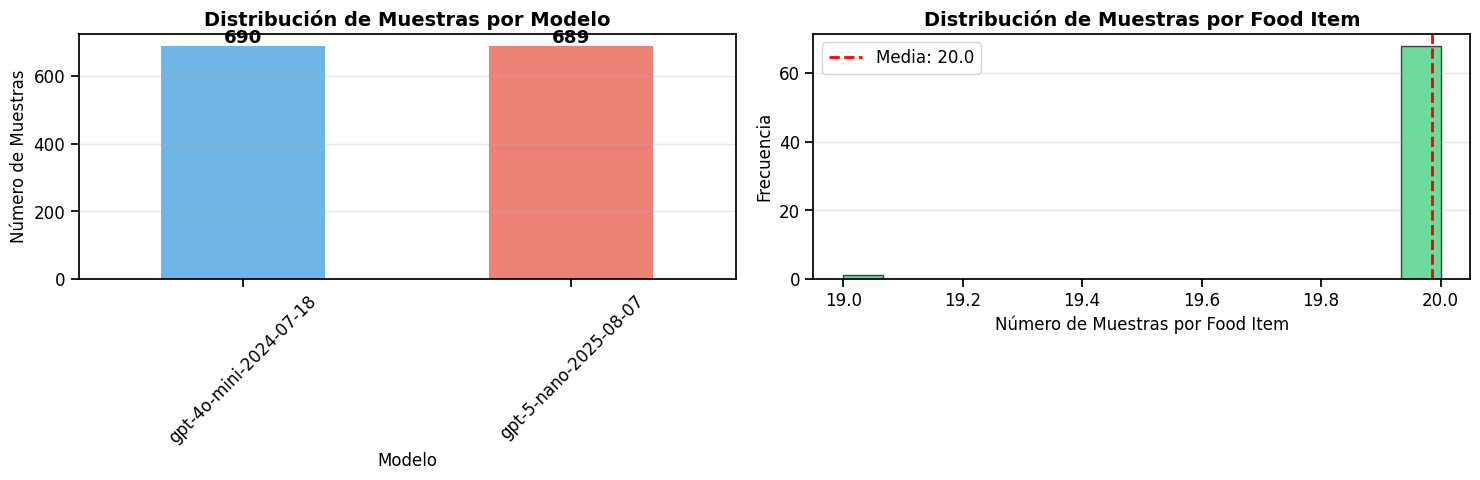


📈 Estadísticas de muestras por food item:
   - Media: 19.99
   - Mediana: 20.00
   - Min: 19
   - Max: 20


In [5]:
# Visualizar distribución de muestras
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Gráfico 1: Muestras por modelo
model_counts.plot(kind='bar', ax=axes[0], color=['#3498db', '#e74c3c'], alpha=0.7)
axes[0].set_title('Distribución de Muestras por Modelo', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Modelo', fontsize=12)
axes[0].set_ylabel('Número de Muestras', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

# Añadir valores en las barras
for i, v in enumerate(model_counts.values):
    axes[0].text(i, v + 10, str(v), ha='center', fontweight='bold')

# Gráfico 2: Distribución de muestras por food item (histograma)
food_sample_counts = df['food_item'].value_counts().values
axes[1].hist(food_sample_counts, bins=15, color='#2ecc71', alpha=0.7, edgecolor='black')
axes[1].set_title('Distribución de Muestras por Food Item', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Número de Muestras por Food Item', fontsize=12)
axes[1].set_ylabel('Frecuencia', fontsize=12)
axes[1].grid(axis='y', alpha=0.3)
axes[1].axvline(food_sample_counts.mean(), color='red', linestyle='--', 
                linewidth=2, label=f'Media: {food_sample_counts.mean():.1f}')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"\n📈 Estadísticas de muestras por food item:")
print(f"   - Media: {food_sample_counts.mean():.2f}")
print(f"   - Mediana: {np.median(food_sample_counts):.2f}")
print(f"   - Min: {food_sample_counts.min()}")
print(f"   - Max: {food_sample_counts.max()}")

## 4. Data Transformation: Text to Numerical Features

Transformamos las dimensiones textuales en métricas cuantitativas para el análisis ANOVA.

### Métricas Extraídas por Dimensión:
1. **Term Count**: Número de descriptores separados por underscore
2. **Average Term Length**: Longitud promedio de los términos (complejidad)
3. **Unique Term Ratio**: Ratio de términos únicos (diversidad léxica)
4. **Total Character Length**: Longitud total de la cadena

In [19]:
def extract_dimension_features(text_value: str) -> Dict[str, float]:
    """
    Extrae features numéricas de una dimensión textual
    
    Args:
        text_value: Valor textual de la dimensión (ej: "rich_creamy_aromatic")
    
    Returns:
        Diccionario con features numéricas
    """
    if pd.isna(text_value) or not isinstance(text_value, str) or len(text_value) == 0:
        return {
            'term_count': 0,
            'avg_term_length': 0,
            'unique_term_ratio': 0,
            'total_char_length': 0
        }
    
    # Separar por underscore
    terms = [term.strip().lower() for term in text_value.split('_')]
    terms = [term for term in terms if term]  # Filtrar vacíos
    
    if len(terms) == 0:
        return {
            'term_count': 0,
            'avg_term_length': 0,
            'unique_term_ratio': 0,
            'total_char_length': 0
        }
    
    # Calcular métricas
    term_count = len(terms)
    avg_term_length = np.mean([len(term) for term in terms])
    unique_terms = len(set(terms))
    unique_term_ratio = unique_terms / term_count if term_count > 0 else 0
    total_char_length = len(text_value)
    
    return {
        'term_count': term_count,
        'avg_term_length': avg_term_length,
        'unique_term_ratio': unique_term_ratio,
        'total_char_length': total_char_length
    }


def transform_dataset_for_anova(df: pd.DataFrame, 
                                dimension: str) -> pd.DataFrame:
    """
    Transforma el dataset para análisis ANOVA de una dimensión específica
    
    Args:
        df: DataFrame original
        dimension: Nombre de la dimensión a analizar
    
    Returns:
        DataFrame con features numéricas para ANOVA
    """
    if dimension not in df.columns:
        raise ValueError(f"Dimensión '{dimension}' no encontrada en el dataset")
    
    print(f"🔄 Transformando dimensión: {dimension}")    
    # Extraer features para cada registro
    features_list = []
    
    for idx, row in df.iterrows():
        text_val = row[dimension]
        features = extract_dimension_features(text_val)
        
        # Añadir información del registro
        features['food_item'] = row['food_item']
        features['model_used'] = row['model_used']
        features['template_name'] = row.get('template_name', 'unknown')
        features['original_text'] = text_val
        
        features_list.append(features)
    
    result_df = pd.DataFrame(features_list)
    
    print(f"✅ Transformación completada")
    print(f"   - Shape: {result_df.shape}")
    print(f"   - Features numéricas: {[col for col in result_df.columns if col not in ['food_item', 'model_used', 'template_name', 'original_text']]}")    
    return result_df


# Definir dimensiones a analizar
DIMENSIONS = ['sensations', 'human_responses', 'temperature', 'texture', 
              'emotions', 'color', 'taste']

print(f"📋 Dimensiones a analizar: {DIMENSIONS}\n")
print(f"   Total: {len(DIMENSIONS)} dimensiones")

📋 Dimensiones a analizar: ['sensations', 'human_responses', 'temperature', 'texture', 'emotions', 'color', 'taste']

   Total: 7 dimensiones


In [7]:
# Ejemplo de transformación para una dimensión
print("🔬 EJEMPLO DE TRANSFORMACIÓN\n" + "="*60)

example_dim = 'sensations'
print(f"\nDimensión de ejemplo: {example_dim}")
print(f"\nPrimeros 5 valores originales:")
print(df[example_dim].head())

# Transformar
example_transformed = transform_dataset_for_anova(df, example_dim)

print(f"\n📊 Primeras 5 filas transformadas:")
example_transformed.head()

🔬 EJEMPLO DE TRANSFORMACIÓN

Dimensión de ejemplo: sensations

Primeros 5 valores originales:
0     cocoa_vanilla_nutty
1    rich_creamy_aromatic
2    bitter_sweet_roasted
3     cocoa_vanilla_nutty
4               chocolate
Name: sensations, dtype: object
🔄 Transformando dimensión: sensations
✅ Transformación completada
   - Shape: (1379, 8)
   - Features numéricas: ['term_count', 'avg_term_length', 'unique_term_ratio', 'total_char_length']

📊 Primeras 5 filas transformadas:


,term_count,avg_term_length,unique_term_ratio,total_char_length,food_item,model_used,template_name,original_text
0,3,5.666667,1.0,19,chocolate,gpt-4o-mini-2024-07-18,sensations_emotions_mapping_no_bias,cocoa_vanilla_nutty
1,3,6.000000,1.0,20,chocolate,gpt-4o-mini-2024-07-18,sensations_emotions_mapping_no_bias,rich_creamy_aromatic
2,3,6.000000,1.0,20,chocolate,gpt-4o-mini-2024-07-18,sensations_emotions_mapping_no_bias,bitter_sweet_roasted
3,3,5.666667,1.0,19,chocolate,gpt-4o-mini-2024-07-18,sensations_emotions_mapping_no_bias,cocoa_vanilla_nutty
4,1,9.000000,1.0,9,chocolate,gpt-4o-mini-2024-07-18,sensations_emotions_mapping_no_bias,chocolate


## 5. Two-Way ANOVA Implementation

Implementamos el análisis ANOVA de dos vías para evaluar:
- **Efecto principal del modelo** (model_used)
- **Efecto principal del alimento** (food_item)  
- **Efecto de interacción** (model_used × food_item)

### Modelo ANOVA:
```
Y_ijk = μ + α_i + β_j + (αβ)_ij + ε_ijk

Donde:
- Y_ijk = variable dependiente (feature numérica)
- μ = media global
- α_i = efecto del modelo i
- β_j = efecto del food_item j
- (αβ)_ij = interacción modelo × food_item
- ε_ijk = error aleatorio
```

In [8]:
def check_anova_assumptions(data: pd.DataFrame, 
                            dependent_var: str,
                            group_var: str) -> Dict[str, Any]:
    """
    Verifica supuestos del ANOVA: normalidad y homogeneidad de varianzas
    
    Args:
        data: DataFrame con los datos
        dependent_var: Nombre de la variable dependiente
        group_var: Nombre de la variable de agrupación
    
    Returns:
        Diccionario con resultados de las pruebas
    """
    results = {
        'normality': {},
        'homogeneity': {}
    }
    
    # Test de normalidad (Shapiro-Wilk) por grupo
    groups = data[group_var].unique()
    normality_pvals = []
    
    for group in groups:
        group_data = data[data[group_var] == group][dependent_var].dropna()
        
        if len(group_data) >= 3:  # Mínimo para Shapiro-Wilk
            stat, pval = shapiro(group_data)
            normality_pvals.append(pval)
            results['normality'][group] = {
                'statistic': stat,
                'p_value': pval,
                'normal': pval > 0.05
            }
    
    # Test de homogeneidad de varianzas (Levene)
    group_data_list = [data[data[group_var] == g][dependent_var].dropna() 
                       for g in groups if len(data[data[group_var] == g][dependent_var].dropna()) > 0]
    
    if len(group_data_list) >= 2:
        stat, pval = levene(*group_data_list)
        results['homogeneity'] = {
            'statistic': stat,
            'p_value': pval,
            'homogeneous': pval > 0.05
        }
    
    return results


def perform_two_way_anova(data: pd.DataFrame,
                          dependent_var: str,
                          dimension_name: str) -> Dict[str, Any]:
    """
    Ejecuta ANOVA de dos vías para una variable dependiente
    
    Args:
        data: DataFrame con variables transformadas
        dependent_var: Nombre de la variable dependiente (ej: 'unique_term_ratio')
        dimension_name: Nombre de la dimensión analizada
    
    Returns:
        Diccionario con resultados del ANOVA
    """
    print(f"\n🔬 Ejecutando Two-Way ANOVA")
    print(f"   Dimensión: {dimension_name}")
    print(f"   Variable dependiente: {dependent_var}")
    
    # Eliminar valores nulos
    clean_data = data[['food_item', 'model_used', dependent_var]].dropna()
    
    if len(clean_data) < 10:
        print(f"   ⚠️  Datos insuficientes: {len(clean_data)} muestras")
        return None
    
    print(f"   Muestras válidas: {len(clean_data)}")
    
    # Verificar supuestos
    print(f"\n   📋 Verificando supuestos...")
    
    # Supuesto de normalidad por modelo
    norm_check = check_anova_assumptions(clean_data, dependent_var, 'model_used')
    normal_pvals = [v['p_value'] for v in norm_check['normality'].values()]
    all_normal = all(pval > 0.05 for pval in normal_pvals)
    
    # Supuesto de homogeneidad de varianzas
    homog_pval = norm_check['homogeneity'].get('p_value', 1.0)
    is_homogeneous = homog_pval > 0.05
    
    print(f"   ✓ Normalidad: {'✅ Pass' if all_normal else '⚠️  Fail (pero ANOVA es robusto)'}")
    print(f"   ✓ Homogeneidad: {'✅ Pass' if is_homogeneous else '⚠️  Fail (usar Type III SS)'}")
    
    # Construir fórmula para ANOVA
    formula = f'{dependent_var} ~ C(model_used) + C(food_item) + C(model_used):C(food_item)'
    
    try:
        # Ajustar modelo OLS
        model = ols(formula, data=clean_data).fit()
        
        # Tabla ANOVA con Type II o Type III SS (Type III para diseños no balanceados)
        anova_table = anova_lm(model, typ=3)
        
        # Extraer resultados
        results = {
            'dimension': dimension_name,
            'dependent_var': dependent_var,
            'n_samples': len(clean_data),
            'anova_table': anova_table,
            'model': model,
            'assumptions': {
                'normality': norm_check,
                'all_normal': all_normal,
                'homogeneous': is_homogeneous
            }
        }
        
        # Calcular effect sizes (Eta-squared)
        ss_total = anova_table['sum_sq'].sum()
        results['effect_sizes'] = {
            'model_used': anova_table.loc['C(model_used)', 'sum_sq'] / ss_total if 'C(model_used)' in anova_table.index else 0,
            'food_item': anova_table.loc['C(food_item)', 'sum_sq'] / ss_total if 'C(food_item)' in anova_table.index else 0,
            'interaction': anova_table.loc['C(model_used):C(food_item)', 'sum_sq'] / ss_total if 'C(model_used):C(food_item)' in anova_table.index else 0
        }
        
        print(f"\n   ✅ ANOVA completado exitosamente")
        
        return results
        
    except Exception as e:
        print(f"   ❌ Error en ANOVA: {str(e)}")
        return None


def analyze_dimension_complete(df: pd.DataFrame, 
                               dimension: str,
                               feature: str = 'unique_term_ratio') -> Dict[str, Any]:
    """
    Análisis completo de una dimensión: transformación + ANOVA
    
    Args:
        df: DataFrame original
        dimension: Nombre de la dimensión
        feature: Feature a analizar (term_count, avg_term_length, etc.)
    
    Returns:
        Diccionario con resultados completos
    """
    print(f"\n{'='*70}")
    print(f"📊 ANÁLISIS COMPLETO: {dimension.upper()}")
    print(f"{'='*70}")
    
    # Paso 1: Transformar datos
    transformed_data = transform_dataset_for_anova(df, dimension)
    
    # Paso 2: Ejecutar ANOVA
    anova_results = perform_two_way_anova(transformed_data, feature, dimension)
    
    if anova_results is not None:
        # Mostrar resultados principales
        print(f"\n📈 RESULTADOS PRINCIPALES:")
        print(f"\n{anova_results['anova_table']}")
        
        print(f"\n🎯 EFFECT SIZES (η²):")
        for effect, eta_sq in anova_results['effect_sizes'].items():
            interpretation = 'pequeño' if eta_sq < 0.06 else ('mediano' if eta_sq < 0.14 else 'grande')
            print(f"   {effect}: {eta_sq:.6f} ({interpretation})")
    
    return {
        'dimension': dimension,
        'feature': feature,
        'transformed_data': transformed_data,
        'anova_results': anova_results
    }

print("✅ Funciones ANOVA implementadas correctamente")

✅ Funciones ANOVA implementadas correctamente


### 5.1 Run ANOVA for Single Dimension (Example)

Ejecutamos el análisis completo para una dimensión de ejemplo.

In [9]:
# Ejecutar análisis para dimensión 'sensations' como ejemplo
example_results = analyze_dimension_complete(df, 'sensations', feature='unique_term_ratio')

# Guardar para uso posterior
sensations_data = example_results['transformed_data']
sensations_anova = example_results['anova_results']


📊 ANÁLISIS COMPLETO: SENSATIONS
🔄 Transformando dimensión: sensations
✅ Transformación completada
   - Shape: (1379, 8)
   - Features numéricas: ['term_count', 'avg_term_length', 'unique_term_ratio', 'total_char_length']

🔬 Ejecutando Two-Way ANOVA
   Dimensión: sensations
   Variable dependiente: unique_term_ratio
   Muestras válidas: 1379

   📋 Verificando supuestos...
   ✓ Normalidad: ⚠️  Fail (pero ANOVA es robusto)
   ✓ Homogeneidad: ✅ Pass

   ✅ ANOVA completado exitosamente

📈 RESULTADOS PRINCIPALES:

                                  sum_sq      df             F    PR(>F)
Intercept                   1.000000e+01     1.0  5.258475e+04  0.000000
C(model_used)               2.962834e-32     1.0  1.557998e-28  1.000000
C(food_item)                2.513366e-02    68.0  1.943598e+00  0.000012
C(model_used):C(food_item)  1.256641e-02    68.0  9.717670e-01  0.543429
Residual                    2.360000e-01  1241.0           NaN       NaN

🎯 EFFECT SIZES (η²):
   model_used: 0.000000 (

### 5.2 Run ANOVA for All Dimensions

Ejecutamos el análisis ANOVA para todas las dimensiones y almacenamos los resultados.

In [10]:
# Ejecutar ANOVA para todas las dimensiones
all_results = {}

print("🚀 EJECUTANDO ANOVA PARA TODAS LAS DIMENSIONES")
print("="*70)

for dimension in DIMENSIONS:
    try:
        results = analyze_dimension_complete(df, dimension, feature='unique_term_ratio')
        all_results[dimension] = results
        print(f"\n✅ {dimension}: Completado")
    except Exception as e:
        print(f"\n❌ {dimension}: Error - {str(e)}")
        all_results[dimension] = None

print(f"\n{'='*70}")
print(f"✅ ANÁLISIS COMPLETADO PARA {len([r for r in all_results.values() if r is not None])}/{len(DIMENSIONS)} DIMENSIONES")
print(f"{'='*70}")

🚀 EJECUTANDO ANOVA PARA TODAS LAS DIMENSIONES

📊 ANÁLISIS COMPLETO: SENSATIONS
🔄 Transformando dimensión: sensations
✅ Transformación completada
   - Shape: (1379, 8)
   - Features numéricas: ['term_count', 'avg_term_length', 'unique_term_ratio', 'total_char_length']

🔬 Ejecutando Two-Way ANOVA
   Dimensión: sensations
   Variable dependiente: unique_term_ratio
   Muestras válidas: 1379

   📋 Verificando supuestos...
   ✓ Normalidad: ⚠️  Fail (pero ANOVA es robusto)
   ✓ Homogeneidad: ✅ Pass

   ✅ ANOVA completado exitosamente

📈 RESULTADOS PRINCIPALES:

                                  sum_sq      df             F    PR(>F)
Intercept                   1.000000e+01     1.0  5.258475e+04  0.000000
C(model_used)               2.962834e-32     1.0  1.557998e-28  1.000000
C(food_item)                2.513366e-02    68.0  1.943598e+00  0.000012
C(model_used):C(food_item)  1.256641e-02    68.0  9.717670e-01  0.543429
Residual                    2.360000e-01  1241.0           NaN       NaN



### 5.3 Create Summary Table

Creamos una tabla resumen con los resultados principales de todas las dimensiones.

In [11]:
def create_anova_summary_table(all_results: Dict) -> pd.DataFrame:
    """
    Crea tabla resumen con resultados de ANOVA para todas las dimensiones
    
    Args:
        all_results: Diccionario con resultados de todas las dimensiones
    
    Returns:
        DataFrame con resumen
    """
    summary_data = []
    
    for dimension, results in all_results.items():
        if results is None or results['anova_results'] is None:
            continue
            
        anova_res = results['anova_results']
        anova_table = anova_res['anova_table']
        
        # Extraer información relevante
        row = {
            'Dimension': dimension,
            'N': anova_res['n_samples']
        }
        
        # Model effect
        if 'C(model_used)' in anova_table.index:
            row['Model_F'] = anova_table.loc['C(model_used)', 'F']
            row['Model_p'] = anova_table.loc['C(model_used)', 'PR(>F)']
            row['Model_sig'] = '***' if row['Model_p'] < 0.001 else ('**' if row['Model_p'] < 0.01 else ('*' if row['Model_p'] < 0.05 else 'ns'))
            row['Model_η²'] = anova_res['effect_sizes']['model_used']
        
        # Food item effect
        if 'C(food_item)' in anova_table.index:
            row['Food_F'] = anova_table.loc['C(food_item)', 'F']
            row['Food_p'] = anova_table.loc['C(food_item)', 'PR(>F)']
            row['Food_sig'] = '***' if row['Food_p'] < 0.001 else ('**' if row['Food_p'] < 0.01 else ('*' if row['Food_p'] < 0.05 else 'ns'))
            row['Food_η²'] = anova_res['effect_sizes']['food_item']
        
        # Interaction effect
        if 'C(model_used):C(food_item)' in anova_table.index:
            row['Interaction_F'] = anova_table.loc['C(model_used):C(food_item)', 'F']
            row['Interaction_p'] = anova_table.loc['C(model_used):C(food_item)', 'PR(>F)']
            row['Interaction_sig'] = '***' if row['Interaction_p'] < 0.001 else ('**' if row['Interaction_p'] < 0.01 else ('*' if row['Interaction_p'] < 0.05 else 'ns'))
            row['Interaction_η²'] = anova_res['effect_sizes']['interaction']
        
        summary_data.append(row)
    
    summary_df = pd.DataFrame(summary_data)
    
    return summary_df


# Crear tabla resumen
summary_table = create_anova_summary_table(all_results)

print("\n" + "="*100)
print("📊 TABLA RESUMEN DE RESULTADOS ANOVA")
print("="*100)
print("\n Significancia: *** p<0.001, ** p<0.01, * p<0.05, ns = no significativo")
print("Effect Size (η²): pequeño <0.06, mediano 0.06-0.14, grande >0.14\n")

# Mostrar tabla formateada
summary_table_display = summary_table.copy()

# Formatear p-values
for col in ['Model_p', 'Food_p', 'Interaction_p']:
    if col in summary_table_display.columns:
        summary_table_display[col] = summary_table_display[col].apply(lambda x: f'{x:.6f}' if pd.notna(x) else 'N/A')

# Formatear F-statistics y effect sizes
for col in ['Model_F', 'Food_F', 'Interaction_F', 'Model_η²', 'Food_η²', 'Interaction_η²']:
    if col in summary_table_display.columns:
        summary_table_display[col] = summary_table_display[col].apply(lambda x: f'{x:.3f}' if pd.notna(x) else 'N/A')

summary_table_display


📊 TABLA RESUMEN DE RESULTADOS ANOVA

 Significancia: *** p<0.001, ** p<0.01, * p<0.05, ns = no significativo
Effect Size (η²): pequeño <0.06, mediano 0.06-0.14, grande >0.14



,Dimension,N,Model_F,Model_p,Model_sig,Model_η²,Food_F,Food_p,Food_sig,Food_η²,Interaction_F,Interaction_p,Interaction_sig,Interaction_η²
0,sensations,1379,0.000,1.000000,ns,0.000,1.944,0.000012,***,0.002,0.972,0.543429,ns,0.001
1,human_responses,1379,66.107,0.000000,***,0.019,0.213,1.000000,ns,0.004,9.022,0.000000,***,0.180
2,temperature,1379,65.700,0.000000,***,0.019,0.212,1.000000,ns,0.004,8.775,0.000000,***,0.177
3,texture,1379,65.700,0.000000,***,0.019,0.212,1.000000,ns,0.004,8.775,0.000000,***,0.177
4,emotions,1379,65.700,0.000000,***,0.019,0.212,1.000000,ns,0.004,8.775,0.000000,***,0.177
5,color,1379,65.700,0.000000,***,0.019,0.212,1.000000,ns,0.004,8.775,0.000000,***,0.177
6,taste,1379,49.862,0.000000,***,0.017,0.161,1.000000,ns,0.004,6.787,0.000000,***,0.161


### 5.4 Key Findings Interpretation

Interpretamos los resultados principales del análisis ANOVA.

In [12]:
print("\n" + "="*80)
print("🔍 INTERPRETACIÓN DE RESULTADOS CLAVE")
print("="*80)

# 1. Efecto del modelo
print("\n1️⃣  EFECTO PRINCIPAL DEL MODELO (model_used):")
print("-" * 80)
model_sig_dims = summary_table[summary_table['Model_sig'] != 'ns']['Dimension'].tolist()
if model_sig_dims:
    print(f"   ✅ Dimensiones con diferencia significativa entre modelos:")
    for dim in model_sig_dims:
        row = summary_table[summary_table['Dimension'] == dim].iloc[0]
        print(f"      • {dim}: F={row['Model_F']:.3f}, p={row['Model_p']:.6f}, η²={row['Model_η²']:.3f} {row['Model_sig']}")
else:
    print("   ⚠️  No se encontraron diferencias significativas entre modelos")

# 2. Efecto del food item
print("\n2️⃣  EFECTO PRINCIPAL DEL ALIMENTO (food_item):")
print("-" * 80)
food_sig_dims = summary_table[summary_table['Food_sig'] != 'ns']['Dimension'].tolist()
if food_sig_dims:
    print(f"   ✅ Dimensiones con diferencia significativa entre alimentos:")
    for dim in food_sig_dims:
        row = summary_table[summary_table['Dimension'] == dim].iloc[0]
        print(f"      • {dim}: F={row['Food_F']:.3f}, p={row['Food_p']:.6f}, η²={row['Food_η²']:.3f} {row['Food_sig']}")
else:
    print("   ⚠️  No se encontraron diferencias significativas entre alimentos")

# 3. Efecto de interacción
print("\n3️⃣  EFECTO DE INTERACCIÓN (model × food_item):")
print("-" * 80)
interaction_sig_dims = summary_table[summary_table['Interaction_sig'] != 'ns']['Dimension'].tolist()
if interaction_sig_dims:
    print(f"   ✅ Dimensiones con interacción significativa:")
    for dim in interaction_sig_dims:
        row = summary_table[summary_table['Dimension'] == dim].iloc[0]
        print(f"      • {dim}: F={row['Interaction_F']:.3f}, p={row['Interaction_p']:.6f}, η²={row['Interaction_η²']:.3f} {row['Interaction_sig']}")
    print("\n   💡 Interpretación: Los modelos se comportan de manera diferente según el alimento")
else:
    print("   ✅ No hay interacción significativa")
    print("   💡 Interpretación: Los modelos se comportan consistentemente a través de todos los alimentos")

# 4. Resumen general
print("\n4️⃣  RESUMEN GENERAL:")
print("-" * 80)
print(f"   📊 Dimensiones analizadas: {len(summary_table)}")
print(f"   🤖 Dimensiones con efecto de modelo: {len(model_sig_dims)}/{len(summary_table)}")
print(f"   🍕 Dimensiones con efecto de alimento: {len(food_sig_dims)}/{len(summary_table)}")
print(f"   🔀 Dimensiones con interacción: {len(interaction_sig_dims)}/{len(summary_table)}")

# Calcular effect sizes promedio
avg_model_eta = summary_table['Model_η²'].mean()
avg_food_eta = summary_table['Food_η²'].mean()
avg_interaction_eta = summary_table['Interaction_η²'].mean()

print(f"\n   📈 Effect sizes promedio (η²):")
print(f"      • Modelo: {avg_model_eta:.6f}")
print(f"      • Alimento: {avg_food_eta:.6f}")
print(f"      • Interacción: {avg_interaction_eta:.6f}")

print("\n" + "="*80)


🔍 INTERPRETACIÓN DE RESULTADOS CLAVE

1️⃣  EFECTO PRINCIPAL DEL MODELO (model_used):
--------------------------------------------------------------------------------
   ✅ Dimensiones con diferencia significativa entre modelos:
      • human_responses: F=66.107, p=0.000000, η²=0.019 ***
      • temperature: F=65.700, p=0.000000, η²=0.019 ***
      • texture: F=65.700, p=0.000000, η²=0.019 ***
      • emotions: F=65.700, p=0.000000, η²=0.019 ***
      • color: F=65.700, p=0.000000, η²=0.019 ***
      • taste: F=49.862, p=0.000000, η²=0.017 ***

2️⃣  EFECTO PRINCIPAL DEL ALIMENTO (food_item):
--------------------------------------------------------------------------------
   ✅ Dimensiones con diferencia significativa entre alimentos:
      • sensations: F=1.944, p=0.000012, η²=0.002 ***

3️⃣  EFECTO DE INTERACCIÓN (model × food_item):
--------------------------------------------------------------------------------
   ✅ Dimensiones con interacción significativa:
      • human_responses: F

## 6. Comprehensive Visualizations

Creamos visualizaciones detalladas para interpretar los resultados del ANOVA:
- **Interaction Plots**: Visualizar interacciones modelo × alimento
- **Boxplots**: Comparar distribuciones entre modelos
- **Heatmaps**: Mostrar F-statistics y p-values
- **Effect Size Plots**: Visualizar tamaños de efecto


📊 Creando visualizaciones de resumen...


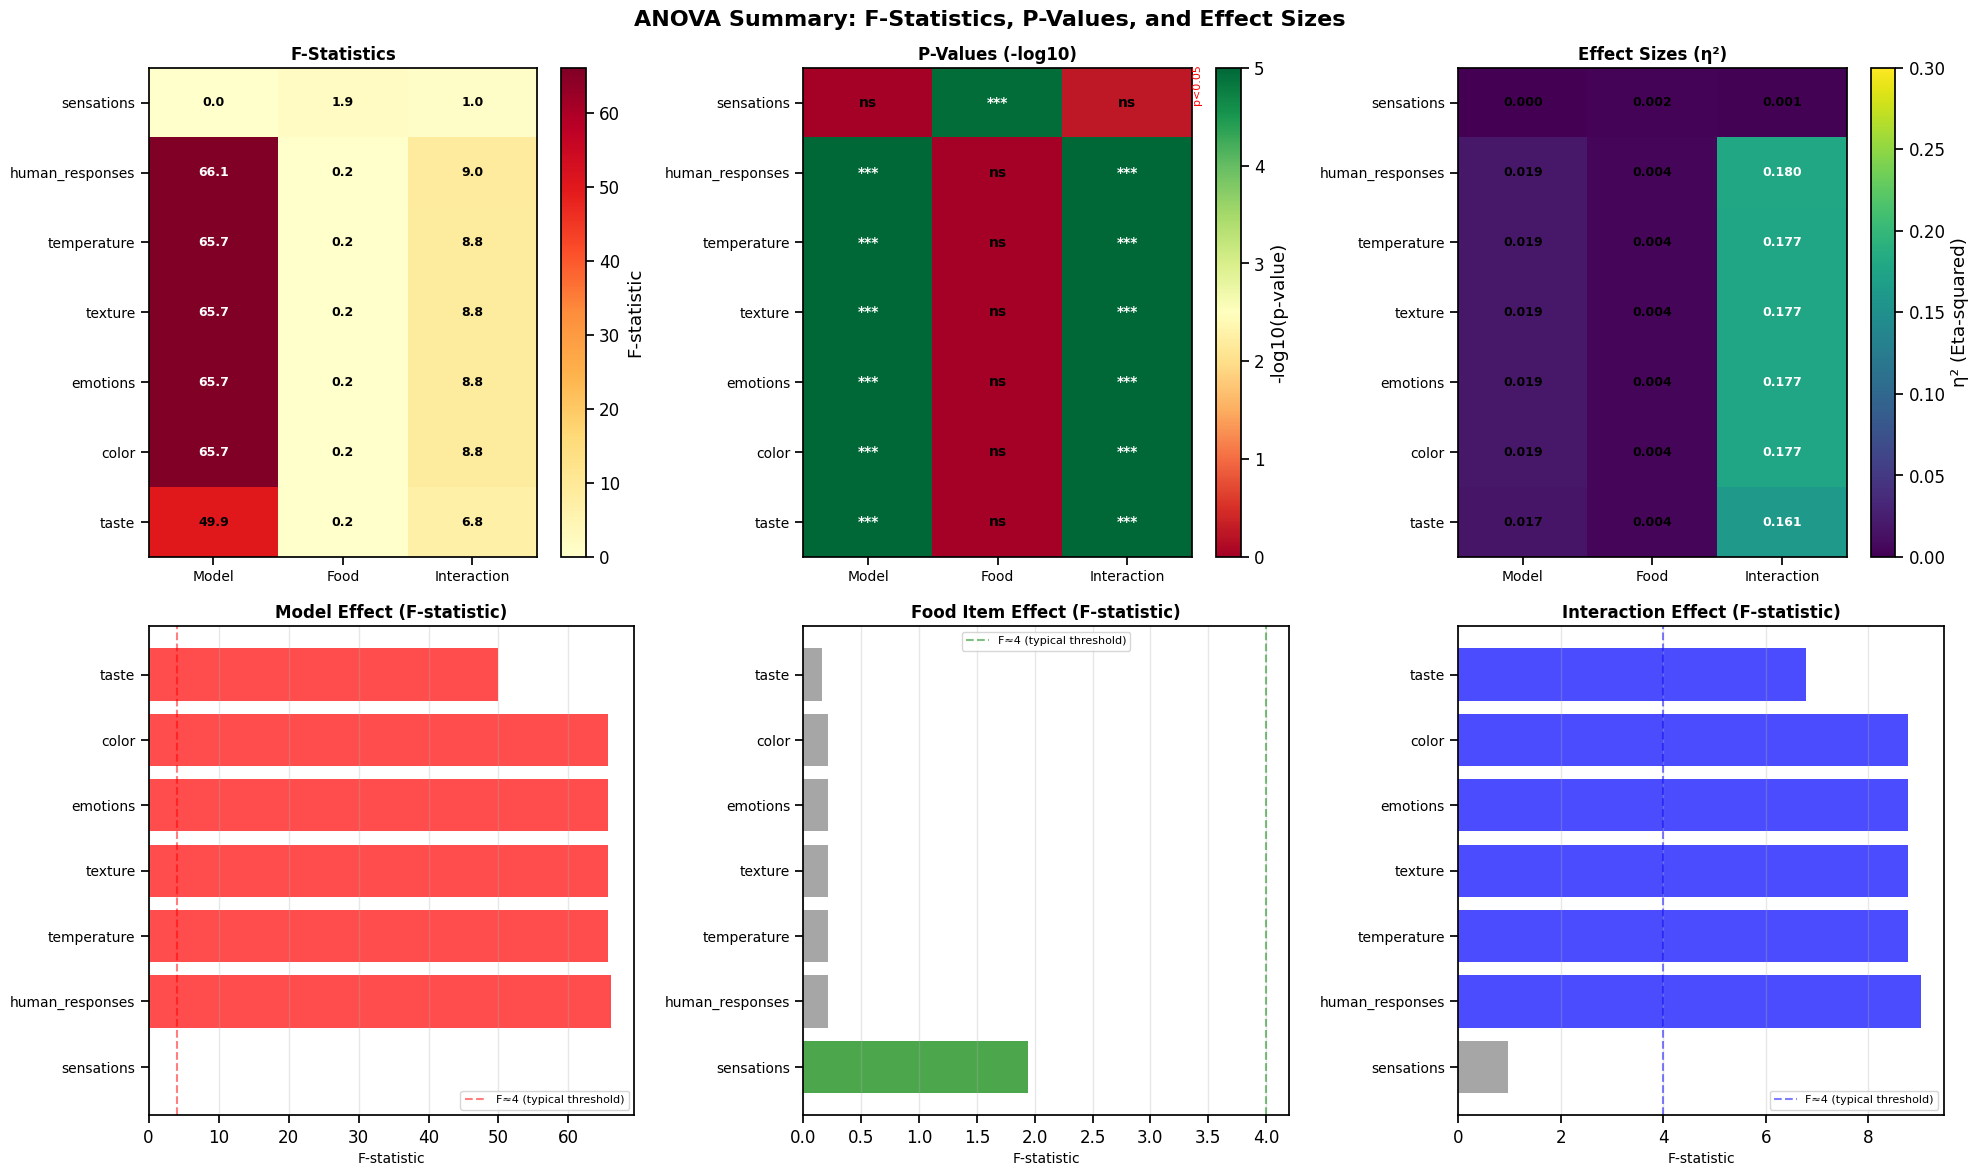

In [13]:
def plot_summary_heatmaps(summary_table: pd.DataFrame) -> None:
    """
    Crea heatmaps de F-statistics, p-values y effect sizes
    
    Args:
        summary_table: DataFrame con resumen de resultados ANOVA
    """
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle('ANOVA Summary: F-Statistics, P-Values, and Effect Sizes', 
                 fontsize=16, fontweight='bold')
    
    # Preparar datos para heatmaps
    dimensions = summary_table['Dimension'].values
    
    # 1. F-Statistics Heatmap
    f_stats_data = summary_table[['Model_F', 'Food_F', 'Interaction_F']].values
    
    im1 = axes[0, 0].imshow(f_stats_data, cmap='YlOrRd', aspect='auto')
    axes[0, 0].set_yticks(range(len(dimensions)))
    axes[0, 0].set_yticklabels(dimensions, fontsize=10)
    axes[0, 0].set_xticks([0, 1, 2])
    axes[0, 0].set_xticklabels(['Model', 'Food', 'Interaction'], fontsize=10)
    axes[0, 0].set_title('F-Statistics', fontsize=12, fontweight='bold')
    
    # Añadir valores
    for i in range(len(dimensions)):
        for j in range(3):
            if not np.isnan(f_stats_data[i, j]):
                text = axes[0, 0].text(j, i, f'{f_stats_data[i, j]:.1f}',
                                      ha='center', va='center', 
                                      color='white' if f_stats_data[i, j] > 50 else 'black',
                                      fontsize=9, fontweight='bold')
    
    plt.colorbar(im1, ax=axes[0, 0], label='F-statistic')
    
    # 2. P-Values Heatmap (log scale for better visualization)
    p_vals_data = summary_table[['Model_p', 'Food_p', 'Interaction_p']].values
    p_vals_log = -np.log10(p_vals_data + 1e-10)  # Log transformation
    
    im2 = axes[0, 1].imshow(p_vals_log, cmap='RdYlGn', aspect='auto', vmin=0, vmax=5)
    axes[0, 1].set_yticks(range(len(dimensions)))
    axes[0, 1].set_yticklabels(dimensions, fontsize=10)
    axes[0, 1].set_xticks([0, 1, 2])
    axes[0, 1].set_xticklabels(['Model', 'Food', 'Interaction'], fontsize=10)
    axes[0, 1].set_title('P-Values (-log10)', fontsize=12, fontweight='bold')
    
    # Añadir líneas de significancia
    axes[0, 1].axhline(y=-0.5, color='red', linestyle='--', alpha=0.3)
    axes[0, 1].text(2.5, 0, 'p<0.05', fontsize=8, color='red', rotation=90)
    
    # Añadir valores
    for i in range(len(dimensions)):
        for j in range(3):
            if not np.isnan(p_vals_data[i, j]):
                sig = '***' if p_vals_data[i, j] < 0.001 else ('**' if p_vals_data[i, j] < 0.01 else ('*' if p_vals_data[i, j] < 0.05 else 'ns'))
                text = axes[0, 1].text(j, i, sig,
                                      ha='center', va='center',
                                      color='white' if p_vals_log[i, j] > 2.5 else 'black',
                                      fontsize=10, fontweight='bold')
    
    plt.colorbar(im2, ax=axes[0, 1], label='-log10(p-value)')
    
    # 3. Effect Sizes (η²) Heatmap
    eta_sq_data = summary_table[['Model_η²', 'Food_η²', 'Interaction_η²']].values
    
    im3 = axes[0, 2].imshow(eta_sq_data, cmap='viridis', aspect='auto', vmin=0, vmax=0.3)
    axes[0, 2].set_yticks(range(len(dimensions)))
    axes[0, 2].set_yticklabels(dimensions, fontsize=10)
    axes[0, 2].set_xticks([0, 1, 2])
    axes[0, 2].set_xticklabels(['Model', 'Food', 'Interaction'], fontsize=10)
    axes[0, 2].set_title('Effect Sizes (η²)', fontsize=12, fontweight='bold')
    
    # Añadir valores
    for i in range(len(dimensions)):
        for j in range(3):
            if not np.isnan(eta_sq_data[i, j]):
                text = axes[0, 2].text(j, i, f'{eta_sq_data[i, j]:.3f}',
                                      ha='center', va='center',
                                      color='white' if eta_sq_data[i, j] > 0.15 else 'black',
                                      fontsize=9, fontweight='bold')
    
    plt.colorbar(im3, ax=axes[0, 2], label='η² (Eta-squared)')
    
    # 4. Model Effect Comparison (Bar plot)
    model_f = summary_table['Model_F'].values
    model_sig = summary_table['Model_sig'].values
    colors_model = ['red' if sig != 'ns' else 'gray' for sig in model_sig]
    
    axes[1, 0].barh(range(len(dimensions)), model_f, color=colors_model, alpha=0.7)
    axes[1, 0].set_yticks(range(len(dimensions)))
    axes[1, 0].set_yticklabels(dimensions, fontsize=10)
    axes[1, 0].set_xlabel('F-statistic', fontsize=10)
    axes[1, 0].set_title('Model Effect (F-statistic)', fontsize=12, fontweight='bold')
    axes[1, 0].axvline(x=4, color='red', linestyle='--', alpha=0.5, label='F≈4 (typical threshold)')
    axes[1, 0].legend(fontsize=8)
    axes[1, 0].grid(axis='x', alpha=0.3)
    
    # 5. Food Effect Comparison (Bar plot)
    food_f = summary_table['Food_F'].values
    food_sig = summary_table['Food_sig'].values
    colors_food = ['green' if sig != 'ns' else 'gray' for sig in food_sig]
    
    axes[1, 1].barh(range(len(dimensions)), food_f, color=colors_food, alpha=0.7)
    axes[1, 1].set_yticks(range(len(dimensions)))
    axes[1, 1].set_yticklabels(dimensions, fontsize=10)
    axes[1, 1].set_xlabel('F-statistic', fontsize=10)
    axes[1, 1].set_title('Food Item Effect (F-statistic)', fontsize=12, fontweight='bold')
    axes[1, 1].axvline(x=4, color='green', linestyle='--', alpha=0.5, label='F≈4 (typical threshold)')
    axes[1, 1].legend(fontsize=8)
    axes[1, 1].grid(axis='x', alpha=0.3)
    
    # 6. Interaction Effect Comparison (Bar plot)
    interaction_f = summary_table['Interaction_F'].values
    interaction_sig = summary_table['Interaction_sig'].values
    colors_interaction = ['blue' if sig != 'ns' else 'gray' for sig in interaction_sig]
    
    axes[1, 2].barh(range(len(dimensions)), interaction_f, color=colors_interaction, alpha=0.7)
    axes[1, 2].set_yticks(range(len(dimensions)))
    axes[1, 2].set_yticklabels(dimensions, fontsize=10)
    axes[1, 2].set_xlabel('F-statistic', fontsize=10)
    axes[1, 2].set_title('Interaction Effect (F-statistic)', fontsize=12, fontweight='bold')
    axes[1, 2].axvline(x=4, color='blue', linestyle='--', alpha=0.5, label='F≈4 (typical threshold)')
    axes[1, 2].legend(fontsize=8)
    axes[1, 2].grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Crear heatmaps de resumen
print("\n📊 Creando visualizaciones de resumen...")
plot_summary_heatmaps(summary_table)

### 6.1 Model Comparison Boxplots

Comparamos las distribuciones de term_count entre modelos para cada dimensión.


📦 Creando boxplots de comparación de modelos...


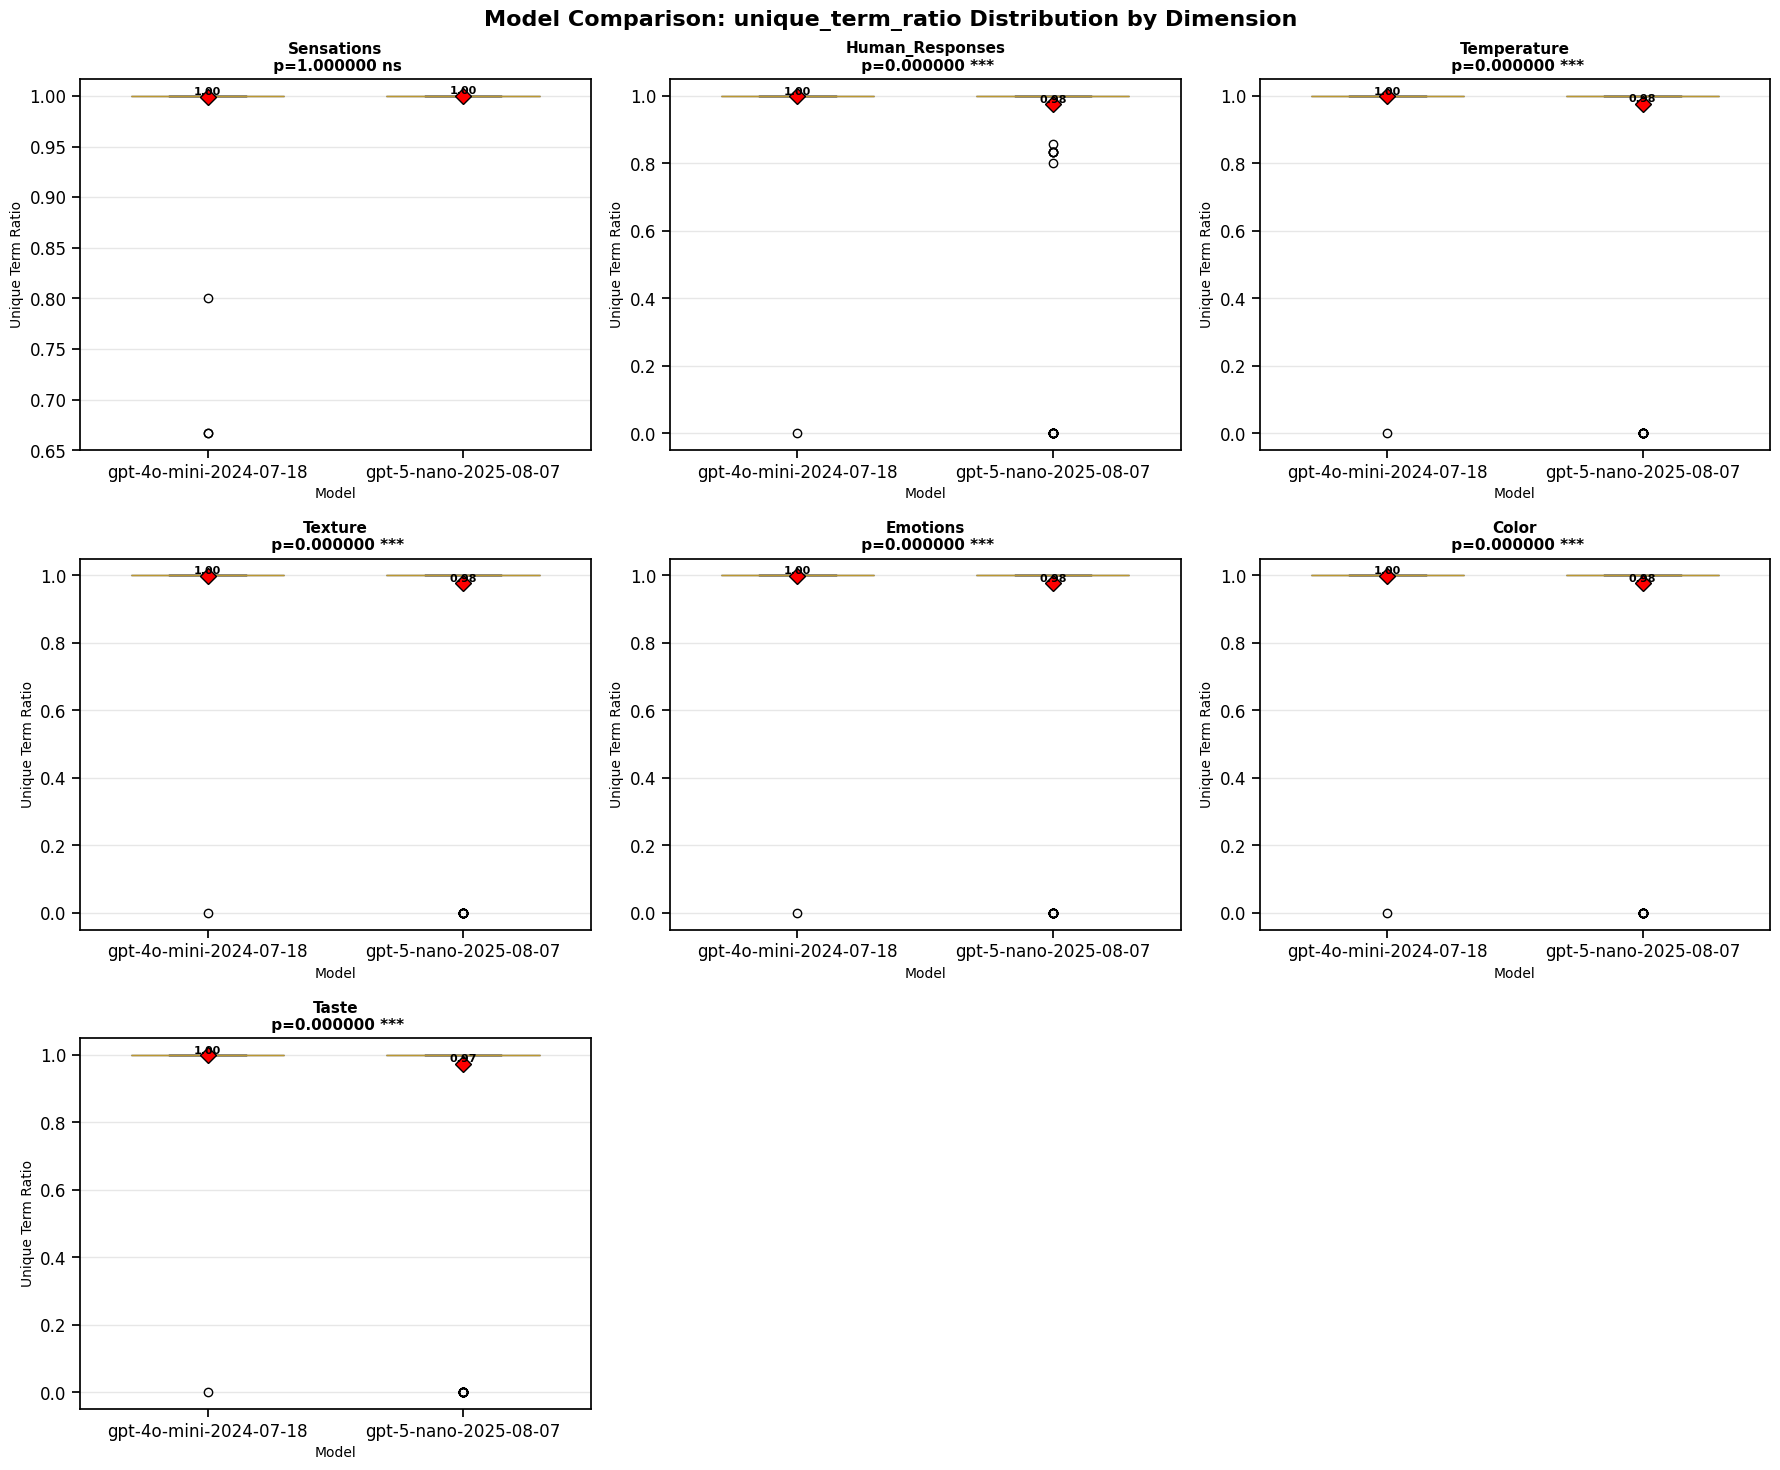

In [14]:
def plot_model_comparison_boxplots(all_results: Dict, feature: str = 'unique_term_ratio') -> None:
    """
    Crea boxplots comparando modelos para cada dimensión
    
    Args:
        all_results: Diccionario con resultados de todas las dimensiones
        feature: Feature a visualizar
    """
    # Calcular número de dimensiones válidas
    valid_dims = [dim for dim, res in all_results.items() if res is not None]
    n_dims = len(valid_dims)
    
    if n_dims == 0:
        print("⚠️  No hay datos válidos para graficar")
        return
    
    # Configurar subplots
    cols = 3
    rows = (n_dims + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(18, 5 * rows))
    fig.suptitle(f'Model Comparison: {feature} Distribution by Dimension', 
                 fontsize=16, fontweight='bold')
    
    # Aplanar axes si hay múltiples filas
    if rows == 1:
        axes = [axes] if n_dims == 1 else axes
    else:
        axes = axes.flatten()
    
    # Colores para los modelos
    colors = {'gpt-4o-mini-2024-07-18': '#3498db', 'gpt-5-nano-2025-08-07': '#e74c3c'}
    
    for idx, dimension in enumerate(valid_dims):
        if idx >= len(axes):
            break
            
        ax = axes[idx]
        results = all_results[dimension]
        
        if results is None or 'transformed_data' not in results:
            ax.text(0.5, 0.5, f'No data\n{dimension}', 
                   ha='center', va='center', transform=ax.transAxes)
            ax.set_title(dimension.title(), fontsize=11)
            continue
        
        data = results['transformed_data']
        
        # Crear boxplot
        models = sorted(data['model_used'].unique())
        positions = range(len(models))
        
        bp = ax.boxplot([data[data['model_used'] == model][feature].values 
                         for model in models],
                        positions=positions,
                        widths=0.6,
                        patch_artist=True,
                        labels=[m for m in models],
                        showfliers=True)
        
        # Colorear boxes
        for patch, model in zip(bp['boxes'], models):
            patch.set_facecolor(colors.get(model, 'gray'))
            patch.set_alpha(0.7)
        
        # Título con información de significancia
        anova_res = results.get('anova_results')
        if anova_res and 'anova_table' in anova_res:
            anova_table = anova_res['anova_table']
            if 'C(model_used)' in anova_table.index:
                p_val = anova_table.loc['C(model_used)', 'PR(>F)']
                sig = '***' if p_val < 0.001 else ('**' if p_val < 0.01 else ('*' if p_val < 0.05 else 'ns'))
                ax.set_title(f'{dimension.title()}\n p={p_val:.6f} {sig}', 
                            fontsize=11, fontweight='bold')
            else:
                ax.set_title(dimension.title(), fontsize=11)
        else:
            ax.set_title(dimension.title(), fontsize=11)
        
        ax.set_ylabel(feature.replace('_', ' ').title(), fontsize=10)
        ax.set_xlabel('Model', fontsize=10)
        ax.grid(axis='y', alpha=0.3)
        
        # Añadir medias
        for i, model in enumerate(models):
            model_data = data[data['model_used'] == model][feature].values
            mean_val = np.mean(model_data)
            ax.plot(i, mean_val, 'D', color='red', markersize=8, 
                   markeredgecolor='black', markeredgewidth=1, zorder=3)
            ax.text(i, mean_val, f'{mean_val:.2f}', 
                   ha='center', va='bottom', fontsize=8, fontweight='bold')
    
    # Ocultar subplots vacíos
    for idx in range(n_dims, len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()

# Crear boxplots
print("\n📦 Creando boxplots de comparación de modelos...")
plot_model_comparison_boxplots(all_results, feature='unique_term_ratio')

### 6.2 Interaction Plots

Visualizamos las interacciones entre modelo y alimento para dimensiones con interacción significativa.


🔀 Creando interaction plots...


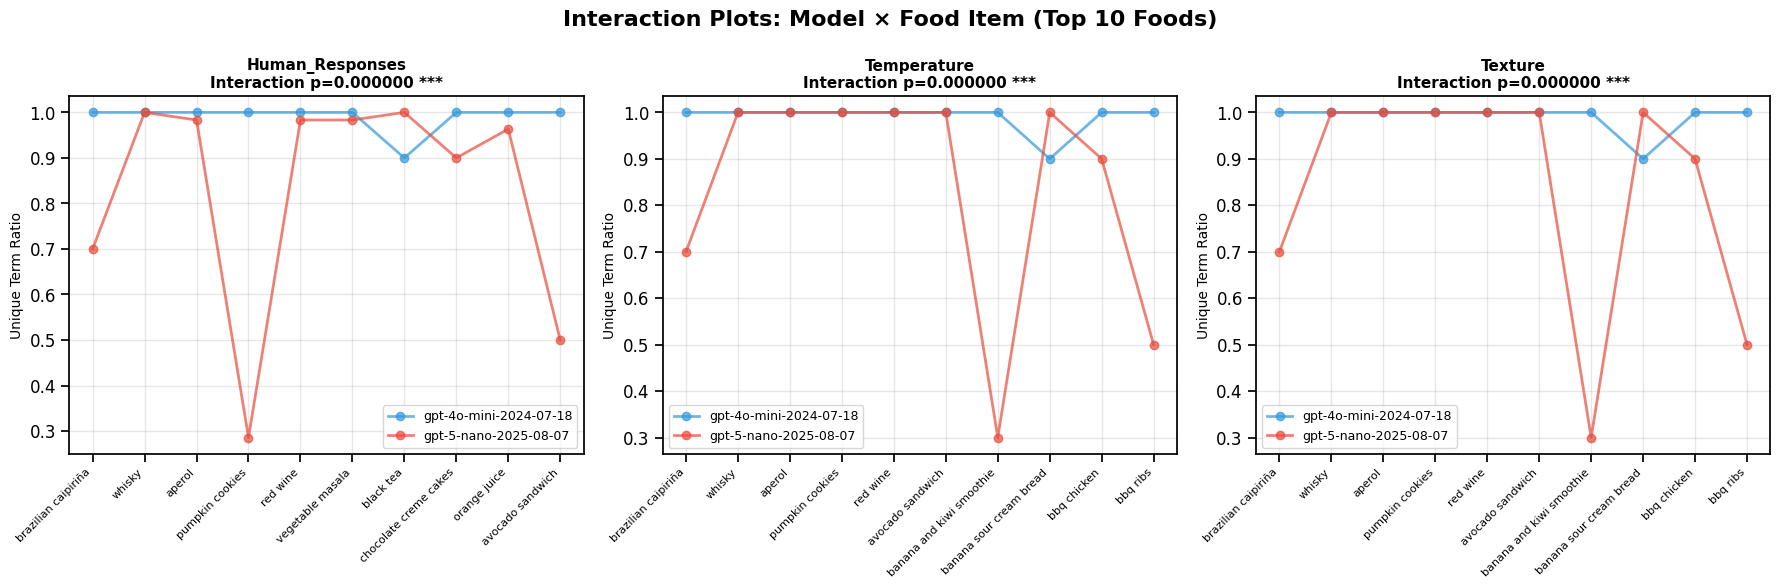


📊 INTERPRETACIÓN DE INTERACTION PLOTS:
--------------------------------------------------------------------------------
• Líneas paralelas → No hay interacción (efecto consistente del modelo)
• Líneas que se cruzan → Interacción presente (efecto depende del alimento)
• Mayor separación → Mayor diferencia entre modelos para ese alimento


In [15]:
def plot_interaction_analysis(all_results: Dict, 
                             summary_table: pd.DataFrame,
                             feature: str = 'unique_term_ratio',
                             top_foods: int = 10) -> None:
    """
    Crea interaction plots para dimensiones con interacción significativa
    
    Args:
        all_results: Diccionario con resultados
        summary_table: Tabla resumen con significancias
        feature: Feature a analizar
        top_foods: Número de alimentos top a mostrar
    """
    # Identificar dimensiones con interacción significativa
    sig_interactions = summary_table[summary_table['Interaction_sig'] != 'ns']
    
    if len(sig_interactions) == 0:
        print("⚠️  No hay interacciones significativas para visualizar")
        # Mostrar dimensión con mayor F-statistic de interacción
        max_interaction = summary_table.loc[summary_table['Interaction_F'].idxmax()]
        print(f"\n💡 Mostrando dimensión con mayor F de interacción: {max_interaction['Dimension']}")
        sig_interactions = summary_table[summary_table['Dimension'] == max_interaction['Dimension']]
    
    n_dims = len(sig_interactions)
    
    fig, axes = plt.subplots(1, min(n_dims, 3), figsize=(18, 6))
    fig.suptitle(f'Interaction Plots: Model × Food Item (Top {top_foods} Foods)', 
                 fontsize=16, fontweight='bold')
    
    if n_dims == 1:
        axes = [axes]
    
    for idx, (_, row) in enumerate(sig_interactions.head(3).iterrows()):
        if idx >= len(axes):
            break
            
        dimension = row['Dimension']
        ax = axes[idx]
        
        if dimension not in all_results or all_results[dimension] is None:
            ax.text(0.5, 0.5, f'No data\n{dimension}', 
                   ha='center', va='center', transform=ax.transAxes)
            continue
        
        data = all_results[dimension]['transformed_data']
        
        # Calcular medias por food_item y modelo
        grouped = data.groupby(['food_item', 'model_used'])[feature].mean().reset_index()
        
        # Seleccionar top N alimentos con mayor variabilidad entre modelos
        variability = []
        for food in grouped['food_item'].unique():
            food_data = grouped[grouped['food_item'] == food]
            if len(food_data) == 2:  # Ambos modelos presentes
                var = abs(food_data[feature].iloc[0] - food_data[feature].iloc[1])
                variability.append((food, var))
        
        variability.sort(key=lambda x: x[1], reverse=True)
        top_food_names = [f[0] for f in variability[:top_foods]]
        
        # Filtrar datos para top foods
        plot_data = grouped[grouped['food_item'].isin(top_food_names)]
        
        # Crear interaction plot
        for model in plot_data['model_used'].unique():
            model_data = plot_data[plot_data['model_used'] == model]
            model_data = model_data.sort_values('food_item')
            
            color = '#3498db' if 'gpt-4o' in model else '#e74c3c'
            label = model#.split('-')[0]
            
            ax.plot(range(len(model_data)), model_data[feature].values, 
                   marker='o', linewidth=2, markersize=6, 
                   label=label, color=color, alpha=0.7)
        
        ax.set_xticks(range(len(top_food_names)))
        ax.set_xticklabels(top_food_names, rotation=45, ha='right', fontsize=8)
        ax.set_ylabel(feature.replace('_', ' ').title(), fontsize=10)
        ax.set_title(f'{dimension.title()}\nInteraction p={row["Interaction_p"]:.6f} {row["Interaction_sig"]}',
                    fontsize=11, fontweight='bold')
        ax.legend(loc='best', fontsize=9)
        ax.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Imprimir interpretación
    print("\n📊 INTERPRETACIÓN DE INTERACTION PLOTS:")
    print("-" * 80)
    print("• Líneas paralelas → No hay interacción (efecto consistente del modelo)")
    print("• Líneas que se cruzan → Interacción presente (efecto depende del alimento)")
    print("• Mayor separación → Mayor diferencia entre modelos para ese alimento")

# Crear interaction plots
print("\n🔀 Creando interaction plots...")
plot_interaction_analysis(all_results, summary_table, feature='unique_term_ratio', top_foods=10)

### 6.3 Effect Size Visualization

Visualizamos los tamaños de efecto (η²) para interpretar la magnitud práctica de las diferencias.


📈 Creando visualizaciones de effect sizes...


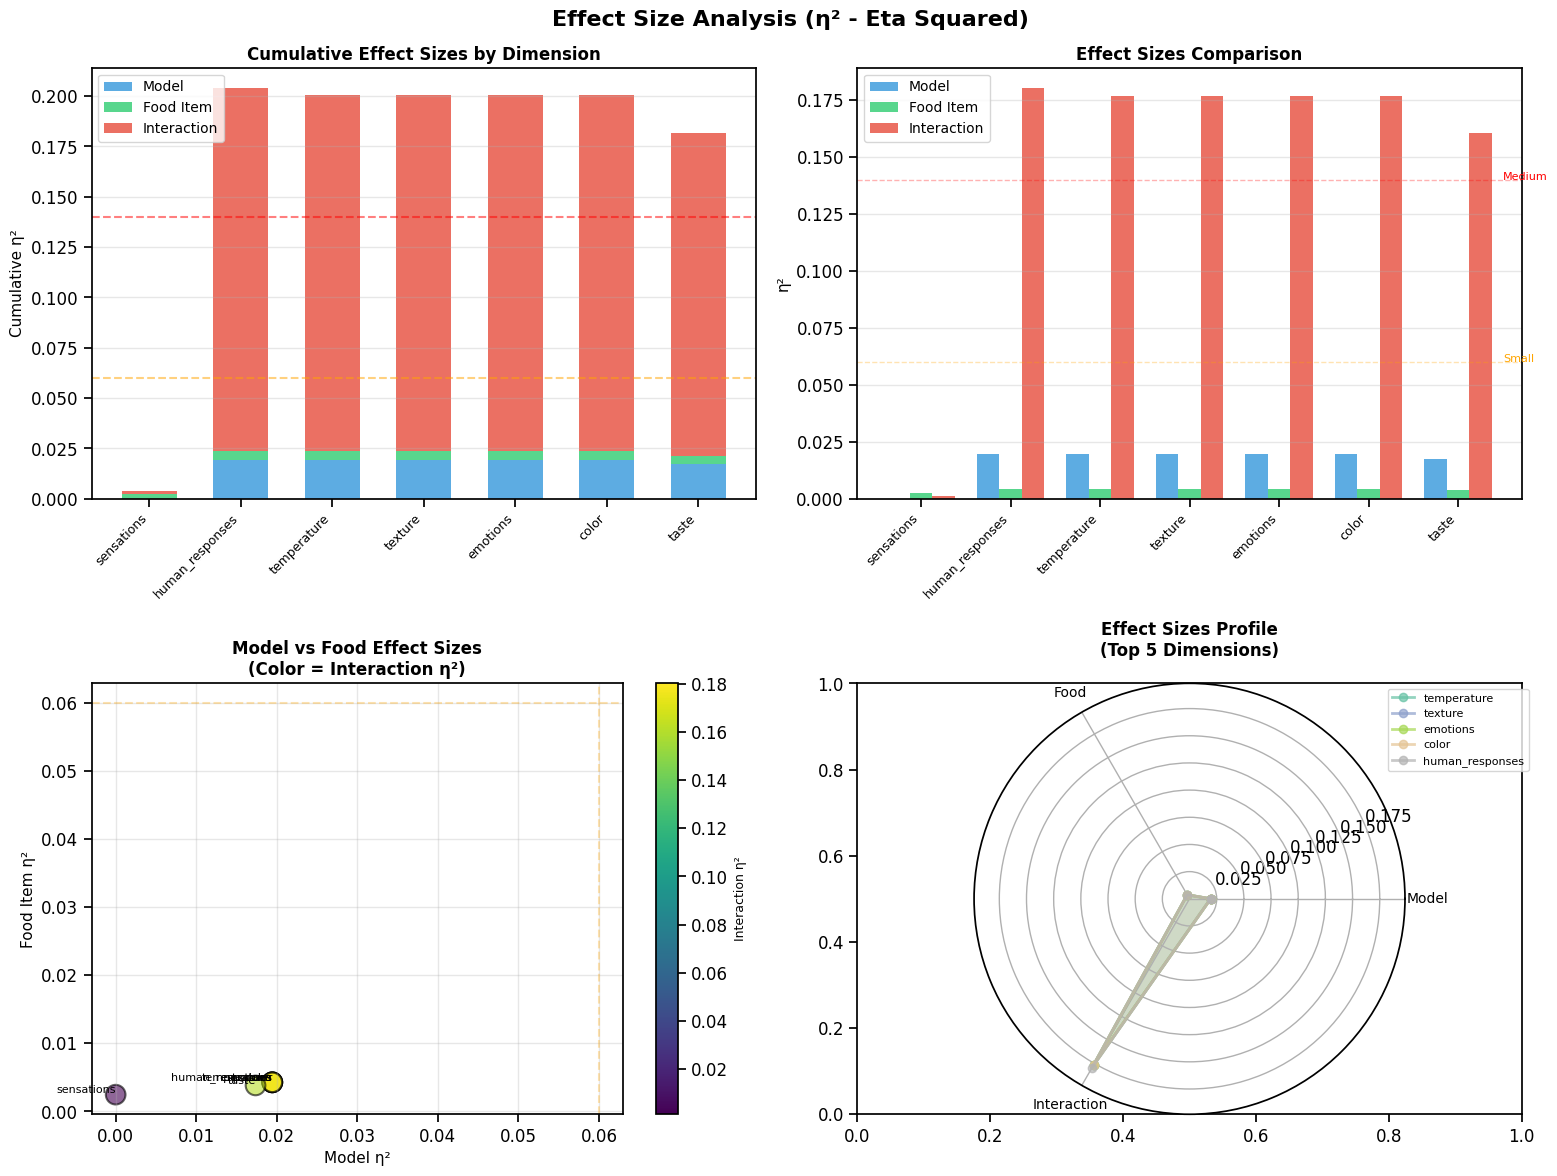


📊 INTERPRETACIÓN DE EFFECT SIZES (η²):
--------------------------------------------------------------------------------
• η² < 0.06: Efecto pequeño (poca importancia práctica)
• 0.06 ≤ η² < 0.14: Efecto mediano (importancia práctica moderada)
• η² ≥ 0.14: Efecto grande (importancia práctica alta)

• El η² indica qué % de la varianza es explicada por cada factor
• Effect sizes grandes son más importantes que p-values pequeños


In [16]:
def plot_effect_sizes(summary_table: pd.DataFrame) -> None:
    """
    Visualiza los tamaños de efecto (η²) de manera comprehensiva
    
    Args:
        summary_table: DataFrame con resultados resumidos
    """
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Effect Size Analysis (η² - Eta Squared)', 
                 fontsize=16, fontweight='bold')
    
    dimensions = summary_table['Dimension'].values
    model_eta = summary_table['Model_η²'].values
    food_eta = summary_table['Food_η²'].values
    interaction_eta = summary_table['Interaction_η²'].values
    
    # 1. Stacked bar chart de effect sizes
    x = np.arange(len(dimensions))
    width = 0.6
    
    p1 = axes[0, 0].bar(x, model_eta, width, label='Model', color='#3498db', alpha=0.8)
    p2 = axes[0, 0].bar(x, food_eta, width, bottom=model_eta, 
                       label='Food Item', color='#2ecc71', alpha=0.8)
    p3 = axes[0, 0].bar(x, interaction_eta, width, 
                       bottom=model_eta + food_eta,
                       label='Interaction', color='#e74c3c', alpha=0.8)
    
    axes[0, 0].set_ylabel('Cumulative η²', fontsize=11)
    axes[0, 0].set_title('Cumulative Effect Sizes by Dimension', fontsize=12, fontweight='bold')
    axes[0, 0].set_xticks(x)
    axes[0, 0].set_xticklabels(dimensions, rotation=45, ha='right', fontsize=9)
    axes[0, 0].legend(loc='upper left', fontsize=10)
    axes[0, 0].grid(axis='y', alpha=0.3)
    axes[0, 0].axhline(y=0.06, color='orange', linestyle='--', alpha=0.5, label='Small')
    axes[0, 0].axhline(y=0.14, color='red', linestyle='--', alpha=0.5, label='Medium')
    
    # 2. Grouped bar chart
    x = np.arange(len(dimensions))
    width = 0.25
    
    axes[0, 1].bar(x - width, model_eta, width, label='Model', color='#3498db', alpha=0.8)
    axes[0, 1].bar(x, food_eta, width, label='Food Item', color='#2ecc71', alpha=0.8)
    axes[0, 1].bar(x + width, interaction_eta, width, label='Interaction', color='#e74c3c', alpha=0.8)
    
    axes[0, 1].set_ylabel('η²', fontsize=11)
    axes[0, 1].set_title('Effect Sizes Comparison', fontsize=12, fontweight='bold')
    axes[0, 1].set_xticks(x)
    axes[0, 1].set_xticklabels(dimensions, rotation=45, ha='right', fontsize=9)
    axes[0, 1].legend(loc='upper left', fontsize=10)
    axes[0, 1].grid(axis='y', alpha=0.3)
    
    # Añadir líneas de referencia
    axes[0, 1].axhline(y=0.06, color='orange', linestyle='--', alpha=0.3, linewidth=1)
    axes[0, 1].axhline(y=0.14, color='red', linestyle='--', alpha=0.3, linewidth=1)
    axes[0, 1].text(len(dimensions)-0.5, 0.06, 'Small', fontsize=8, color='orange')
    axes[0, 1].text(len(dimensions)-0.5, 0.14, 'Medium', fontsize=8, color='red')
    
    # 3. Scatter plot: Model vs Food effect sizes
    axes[1, 0].scatter(model_eta, food_eta, s=200, alpha=0.6, c=interaction_eta, 
                      cmap='viridis', edgecolors='black', linewidth=1.5)
    
    for i, dim in enumerate(dimensions):
        axes[1, 0].annotate(dim, (model_eta[i], food_eta[i]), 
                          fontsize=8, ha='right', va='bottom')
    
    axes[1, 0].set_xlabel('Model η²', fontsize=11)
    axes[1, 0].set_ylabel('Food Item η²', fontsize=11)
    axes[1, 0].set_title('Model vs Food Effect Sizes\n(Color = Interaction η²)', 
                        fontsize=12, fontweight='bold')
    axes[1, 0].grid(alpha=0.3)
    axes[1, 0].axvline(x=0.06, color='orange', linestyle='--', alpha=0.3)
    axes[1, 0].axhline(y=0.06, color='orange', linestyle='--', alpha=0.3)
    
    # Añadir colorbar
    sm = plt.cm.ScalarMappable(cmap='viridis', 
                               norm=plt.Normalize(vmin=interaction_eta.min(), 
                                                 vmax=interaction_eta.max()))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=axes[1, 0])
    cbar.set_label('Interaction η²', fontsize=9)
    
    # 4. Radar chart / Spider plot de effect sizes
    categories = ['Model', 'Food', 'Interaction']
    
    # Seleccionar dimensiones más interesantes
    top_dims = summary_table.nlargest(5, 'Model_η²')['Dimension'].values
    
    angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
    angles += angles[:1]  # Cerrar el círculo
    
    ax_radar = plt.subplot(224, projection='polar')
    
    colors_radar = plt.cm.Set2(np.linspace(0, 1, len(top_dims)))
    
    for idx, dim in enumerate(top_dims):
        row = summary_table[summary_table['Dimension'] == dim].iloc[0]
        values = [row['Model_η²'], row['Food_η²'], row['Interaction_η²']]
        values += values[:1]  # Cerrar el círculo
        
        ax_radar.plot(angles, values, 'o-', linewidth=2, 
                     label=dim, color=colors_radar[idx], alpha=0.7)
        ax_radar.fill(angles, values, alpha=0.15, color=colors_radar[idx])
    
    ax_radar.set_xticks(angles[:-1])
    ax_radar.set_xticklabels(categories, fontsize=10)
    ax_radar.set_ylim(0, max(summary_table[['Model_η²', 'Food_η²', 'Interaction_η²']].max()) * 1.1)
    ax_radar.set_title('Effect Sizes Profile\n(Top 5 Dimensions)', 
                      fontsize=12, fontweight='bold', pad=20)
    ax_radar.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0), fontsize=8)
    ax_radar.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Interpretación
    print("\n📊 INTERPRETACIÓN DE EFFECT SIZES (η²):")
    print("-" * 80)
    print("• η² < 0.06: Efecto pequeño (poca importancia práctica)")
    print("• 0.06 ≤ η² < 0.14: Efecto mediano (importancia práctica moderada)")
    print("• η² ≥ 0.14: Efecto grande (importancia práctica alta)")
    print("\n• El η² indica qué % de la varianza es explicada por cada factor")
    print("• Effect sizes grandes son más importantes que p-values pequeños")

# Crear visualizaciones de effect sizes
print("\n📈 Creando visualizaciones de effect sizes...")
plot_effect_sizes(summary_table)

## 7. Post-Hoc Analysis (Optional)

Para dimensiones con efectos significativos, realizamos pruebas post-hoc para identificar diferencias específicas entre grupos.

In [17]:
def perform_posthoc_tukey(data: pd.DataFrame, 
                         dimension: str,
                         feature: str = 'unique_term_ratio',
                         factor: str = 'food_item') -> pd.DataFrame:
    """
    Ejecuta prueba post-hoc de Tukey HSD para comparaciones múltiples
    
    Args:
        data: DataFrame con datos transformados
        dimension: Nombre de la dimensión
        feature: Feature a analizar
        factor: Factor a comparar ('food_item' o 'model_used')
    
    Returns:
        DataFrame con resultados de Tukey HSD
    """
    print(f"\n🔬 Ejecutando Tukey HSD para {dimension}")
    print(f"   Factor: {factor}")
    
    # Preparar datos
    clean_data = data[[factor, feature]].dropna()
    
    if len(clean_data) < 10:
        print(f"   ⚠️  Datos insuficientes")
        return None
    
    try:
        # Ejecutar Tukey HSD
        tukey_result = pairwise_tukeyhsd(
            endog=clean_data[feature],
            groups=clean_data[factor],
            alpha=0.05
        )
        
        # Convertir a DataFrame
        tukey_df = pd.DataFrame(data=tukey_result.summary().data[1:], 
                               columns=tukey_result.summary().data[0])
        
        # Filtrar solo comparaciones significativas
        sig_comparisons = tukey_df[tukey_df['reject'] == True]
        
        print(f"   ✅ Tukey completado")
        print(f"   Total comparaciones: {len(tukey_df)}")
        print(f"   Comparaciones significativas: {len(sig_comparisons)}")
        
        return tukey_df
        
    except Exception as e:
        print(f"   ❌ Error: {str(e)}")
        return None


# Ejemplo: Post-hoc para dimensión con efecto significativo de modelo
print("="*80)
print("📊 POST-HOC ANALYSIS: TUKEY HSD")
print("="*80)

# Identificar dimensiones con efecto significativo de modelo
model_sig_dims = summary_table[summary_table['Model_sig'] != 'ns']['Dimension'].tolist()

if model_sig_dims:
    print(f"\n🎯 Dimensiones con efecto significativo de modelo: {model_sig_dims}")
    
    # Ejecutar Tukey para la primera dimensión significativa
    example_dim = model_sig_dims[0]
    if example_dim in all_results and all_results[example_dim] is not None:
        tukey_results = perform_posthoc_tukey(
            all_results[example_dim]['transformed_data'],
            example_dim,
            feature='unique_term_ratio',
            factor='model_used'
        )
        
        if tukey_results is not None and len(tukey_results) > 0:
            print(f"\n📋 Resultados Tukey HSD para {example_dim}:")
            print(tukey_results)
else:
    print("\n⚠️  No hay efectos significativos de modelo para post-hoc")
    print("💡 El post-hoc es más útil cuando hay >2 niveles de un factor")
    print("   Con solo 2 modelos, el ANOVA ya indica la diferencia significativa")

📊 POST-HOC ANALYSIS: TUKEY HSD

🎯 Dimensiones con efecto significativo de modelo: ['human_responses', 'temperature', 'texture', 'emotions', 'color', 'taste']

🔬 Ejecutando Tukey HSD para human_responses
   Factor: model_used
   ✅ Tukey completado
   Total comparaciones: 1
   Comparaciones significativas: 1

📋 Resultados Tukey HSD para human_responses:
                   group1                 group2  meandiff   p-adj   lower  \
0  gpt-4o-mini-2024-07-18  gpt-5-nano-2025-08-07   -0.0232  0.0001 -0.0349   

    upper  reject  
0 -0.0116    True  


## 8. Final Summary and Conclusions

Resumen ejecutivo de los hallazgos del análisis Two-Way ANOVA.

In [18]:
print("\n" + "="*90)
print("🎯 RESUMEN EJECUTIVO: TWO-WAY ANOVA MODEL COMPARISON")
print("="*90)

print("\n📊 DISEÑO EXPERIMENTAL:")
print("-" * 90)
print(f"   • Modelos comparados: gpt-4o-mini-2024-07-18 vs gpt-5-nano-2025-08-07")
print(f"   • Food items analizados: {df['food_item'].nunique()}")
print(f"   • Total muestras: {len(df)}")
print(f"   • Dimensiones analizadas: {len(DIMENSIONS)} → {', '.join(DIMENSIONS)}")

print("\n🔬 RESULTADOS PRINCIPALES:")
print("-" * 90)

# 1. Efecto del modelo
model_sig = summary_table[summary_table['Model_sig'] != 'ns']
print(f"\n1️⃣  EFECTO DEL MODELO:")
if len(model_sig) > 0:
    print(f"   ✅ {len(model_sig)}/{len(DIMENSIONS)} dimensiones muestran diferencias significativas")
    print(f"   📌 Dimensiones con mayor diferencia entre modelos:")
    for _, row in model_sig.nlargest(3, 'Model_η²').iterrows():
        print(f"      • {row['Dimension']}: η²={row['Model_η²']:.6f}, p={row['Model_p']:.6f} {row['Model_sig']}")
else:
    print(f"   ⚠️  Ninguna dimensión muestra diferencias significativas entre modelos")

# 2. Efecto del alimento
food_sig = summary_table[summary_table['Food_sig'] != 'ns']
print(f"\n2️⃣  EFECTO DEL ALIMENTO:")
if len(food_sig) > 0:
    print(f"   ✅ {len(food_sig)}/{len(DIMENSIONS)} dimensiones muestran diferencias significativas")
    print(f"   📌 Dimensiones con mayor variabilidad entre alimentos:")
    for _, row in food_sig.nlargest(3, 'Food_η²').iterrows():
        print(f"      • {row['Dimension']}: η²={row['Food_η²']:.6f}, p={row['Food_p']:.6f} {row['Food_sig']}")
else:
    print(f"   ⚠️  Ninguna dimensión muestra diferencias significativas entre alimentos")

# 3. Interacción
interaction_sig = summary_table[summary_table['Interaction_sig'] != 'ns']
print(f"\n3️⃣  INTERACCIÓN MODELO × ALIMENTO:")
if len(interaction_sig) > 0:
    print(f"   ⚠️  {len(interaction_sig)}/{len(DIMENSIONS)} dimensiones muestran interacción significativa")
    print(f"   📌 Dimensiones donde el efecto del modelo depende del alimento:")
    for _, row in interaction_sig.nlargest(3, 'Interaction_η²').iterrows():
        print(f"      • {row['Dimension']}: η²={row['Interaction_η²']:.6f}, p={row['Interaction_p']:.6f} {row['Interaction_sig']}")
    print(f"\n   💡 Interpretación: Los modelos se comportan de manera diferente según el alimento")
else:
    print(f"   ✅ No hay interacciones significativas")
    print(f"   💡 Interpretación: Los modelos se comportan consistentemente para todos los alimentos")

# 4. Comparación de varianzas
print(f"\n4️⃣  COMPARACIÓN DE VARIANZAS:")
print(f"   • Varianza explicada promedio por modelo: {summary_table['Model_η²'].mean():.6f}")
print(f"   • Varianza explicada promedio por alimento: {summary_table['Food_η²'].mean():.6f}")
print(f"   • Varianza explicada promedio por interacción: {summary_table['Interaction_η²'].mean():.6f}")

if summary_table['Food_η²'].mean() > summary_table['Model_η²'].mean():
    print(f"\n   💡 El tipo de alimento explica más varianza que el modelo usado")
else:
    print(f"\n   💡 El modelo usado explica más varianza que el tipo de alimento")

# 5. Recomendaciones
print(f"\n📋 RECOMENDACIONES:")
print("-" * 90)

if len(model_sig) == 0:
    print("   1. Los modelos generan respuestas muy similares en términos de term_count")
    print("   2. Considerar analizar otras métricas (avg_term_length, unique_term_ratio)")
    print("   3. Ambos modelos pueden ser intercambiables para esta tarea")
elif len(model_sig) > len(DIMENSIONS) / 2:
    print("   1. Los modelos muestran diferencias significativas en la mayoría de dimensiones")
    print("   2. Revisar cuál modelo genera respuestas más apropiadas según el objetivo")
    print("   3. Considerar usar modelos diferentes para diferentes tipos de alimentos")
else:
    print("   1. Los modelos difieren en algunas dimensiones específicas")
    print("   2. Elegir modelo basándose en las dimensiones más importantes para el proyecto")
    print("   3. Validar con métricas de calidad adicionales")

if len(interaction_sig) > 0:
    print(f"   4. ⚠️  IMPORTANTE: Hay interacciones significativas")
    print(f"      → Los modelos no se comportan uniformemente")
    print(f"      → Analizar qué alimentos causan mayores diferencias")

print(f"\n📈 PRÓXIMOS PASOS SUGERIDOS:")
print("-" * 90)
print("   1. Analizar otras features (avg_term_length, unique_term_ratio, total_char_length)")
print("   2. Realizar análisis cualitativo de las respuestas con mayores diferencias")
print("   3. Evaluar calidad semántica de las respuestas (no solo métricas cuantitativas)")
print("   4. Considerar cost-benefit: ¿justifica la diferencia el costo computacional?")

print("\n" + "="*90)
print("✅ ANÁLISIS COMPLETADO")
print("="*90)


🎯 RESUMEN EJECUTIVO: TWO-WAY ANOVA MODEL COMPARISON

📊 DISEÑO EXPERIMENTAL:
------------------------------------------------------------------------------------------
   • Modelos comparados: gpt-4o-mini-2024-07-18 vs gpt-5-nano-2025-08-07
   • Food items analizados: 69
   • Total muestras: 1379
   • Dimensiones analizadas: 7 → sensations, human_responses, temperature, texture, emotions, color, taste

🔬 RESULTADOS PRINCIPALES:
------------------------------------------------------------------------------------------

1️⃣  EFECTO DEL MODELO:
   ✅ 6/7 dimensiones muestran diferencias significativas
   📌 Dimensiones con mayor diferencia entre modelos:
      • temperature: η²=0.019451, p=0.000000 ***
      • texture: η²=0.019451, p=0.000000 ***
      • emotions: η²=0.019451, p=0.000000 ***

2️⃣  EFECTO DEL ALIMENTO:
   ✅ 1/7 dimensiones muestran diferencias significativas
   📌 Dimensiones con mayor variabilidad entre alimentos:
      • sensations: η²=0.002446, p=0.000012 ***

3️⃣  INTERAC